In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
from matplotlib.legend import Legend
from scipy.stats import ranksums, ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower
import statsmodels.stats.multicomp as mc

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

import os
import json

In [6]:
with open('data/paths.json','r') as f:
    paths = json.load(f)

data_path = paths["data_path"]

In [7]:
whole = True

batch_corrected = False
zero_remove = False
scaler_term = 'minmax'
scaler = MinMaxScaler() if scaler_term=='minmax' else StandardScaler()
data_col_idx = 19 if batch_corrected else 16

test_enc_name = '_BatchCor'+str(batch_corrected)+'_NanRem'+str(zero_remove)+'_'+str(scaler_term)

In [8]:
with open(os.path.join('results','significant_metabolites_pls2_treatment'+test_enc_name+'.txt'),'r') as f:
    metabolite_names = f.read().splitlines()
print(metabolite_names)
print(len(metabolite_names))

["2'-O-Methyl Guanosine.1", "2'-O-Methyl Uridine.1", '2-ketoglutaric acid.1', '3-Hydroxyhexadecanoylcarnitine', '3-Hydroxykynurenine.1', '3-Hydroxyoleoylcarnitine', '7-methylguanine.1', '9-Hexadecenoylcarnitine', 'ADP.1', 'ATP.1', 'Adenine.1', 'Adenosine.1', 'Aminoisobutyric acid (BAIBA).1', 'Arachidonyl carnitine', 'Ascorbic acid.1', 'Betaine.1', 'CMP.1', 'Creatinine.1', 'Deoxyguanosine.1', 'Dodecanoylcarnitine', 'Dodecenoylcarnitine', 'Dopamine.1', 'Ethanolamine.1', 'FAD', 'Fructose-1,6-diphosphate', 'GMP.1', 'GTP.1', 'Glucose/Inositol/Gluconolactone/Fructose', 'Glutathione.1', 'IMP.1', 'Isocitric_Citric_acid.1', 'Isoleucine.2', 'Isovalerylcarnitine (C5).1', 'L-Glutarylcarnitine', 'L-Methionine.1', 'L-Palmitoylcarnitine (C16).1', 'L-Tryptophan.1', 'Linoleylcarnitine', 'Myristoylcarnitine (C14).1', 'N4- Acetyl Cytidine.1', 'NAD', 'NADH', 'NADP', 'Oleoylcarnitine', 'Phenylacetylglutamine or Pantothenate.1', 'Phosphoenolpyruvate.1', 'Pimelylcarnitine', 'Riboflavin.1', 'S-methyl-5-thioad

In [9]:
sns.set(style = 'whitegrid')

### Load Data

In [10]:
data_new = pd.read_excel(os.path.join(data_path,"2023_12_laezza_deltamethrin_metabolomics.xlsx"))
data_old = pd.read_excel(os.path.join(data_path,"2022_12_Laezza_Bernabucci_Mouse_Brain_COMBINED_METABOLOMICS.xlsx"))

data_old = data_old[data_old['Sex']=='M']
data_old = data_old[data_old['Tissue Type']=='striatum']
data_old = data_old[data_old['PND']==30]

columns_data = ['LCMS Name', 'Tissue Weight\n(mg)', 'Treatment', 'Metabolite', 'Normalized Peak Area (Peak Area of Metabolite / (Peak Area of Internal Standard * Tissue weight))']
columns_old = ['Sample Name', 'Tissue weight\n(mg)', 'Treatment', 'Metabolite', 'Normalized Peak Area\n(Peak Area of Metabolite / (Peak Area of Internal Standard * Tisue weight))']
columns_new = ['name','weight','treatment','metabolite','area']

data_new = data_new[columns_data]
data_new.columns = columns_new
data_new['batch']=1

data_old = data_old[columns_old]
data_old.columns = columns_new
data_old['batch']=0

In [11]:
if whole:
    data_all = pd.concat([data_new, data_old], axis=0)
    data_all = data_all[data_all['area']!=0]
else:
    data_all = data_new.copy()
    
data_all['area'] = np.log(data_all['area'])

data_all.head()

,name,weight,treatment,metabolite,area,batch
0,Laezza #1,106,control,1 or 3-Methyl-Histidine.1,-4.538732,1
1,Laezza #2,82,control,1 or 3-Methyl-Histidine.1,-3.227442,1
2,Laezza #3,92,control,1 or 3-Methyl-Histidine.1,-4.773899,1
3,Laezza #4,105,control,1 or 3-Methyl-Histidine.1,-3.893745,1
4,Laezza #5,100,control,1 or 3-Methyl-Histidine.1,-4.290535,1


In [13]:
data_all['treatment'] = LabelEncoder().fit_transform(data_all['treatment'])
data_all.head()

,name,weight,treatment,metabolite,area,batch
0,Laezza #1,106,0,1 or 3-Methyl-Histidine.1,-4.538732,1
1,Laezza #2,82,0,1 or 3-Methyl-Histidine.1,-3.227442,1
2,Laezza #3,92,0,1 or 3-Methyl-Histidine.1,-4.773899,1
3,Laezza #4,105,0,1 or 3-Methyl-Histidine.1,-3.893745,1
4,Laezza #5,100,0,1 or 3-Methyl-Histidine.1,-4.290535,1


# FIGURES

### Violin Plots

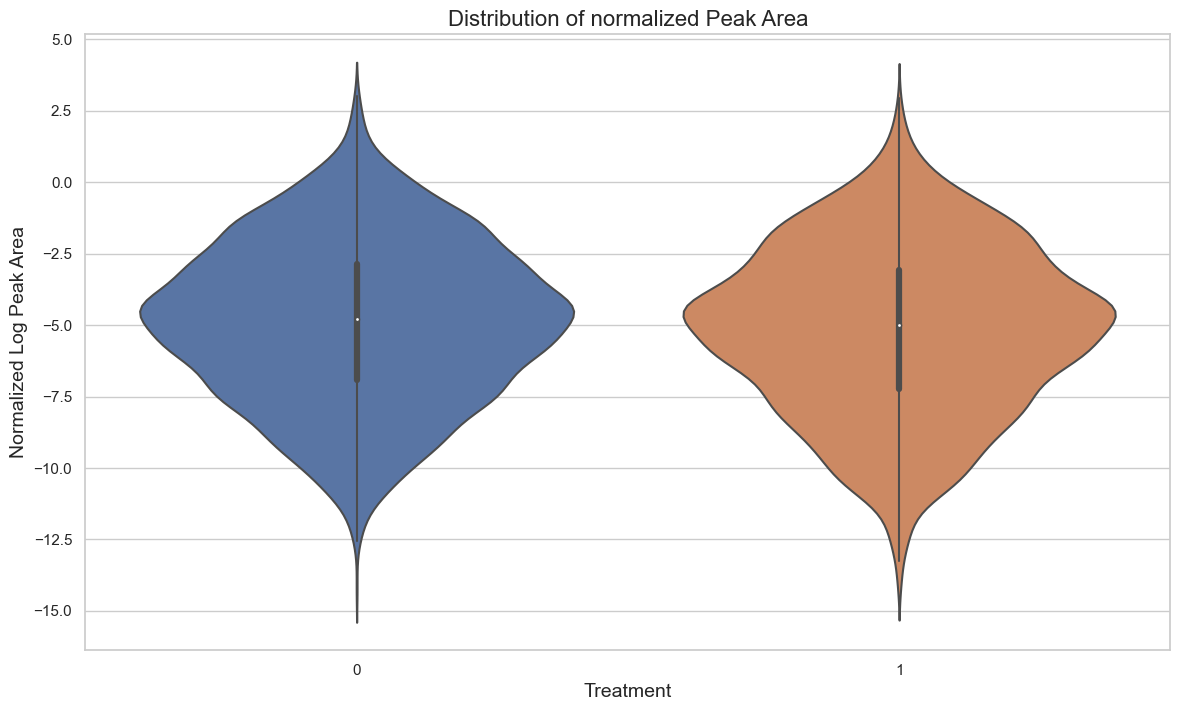

In [14]:
fig = plt.figure(figsize=(14,8), dpi=100)
ax = sns.violinplot(data=data_all, x='treatment', y='area',split=True, inner='box')

ax.set_title('Distribution of normalized Peak Area', fontsize=16)
ax.set_xlabel('Treatment', fontsize=14)
ax.set_ylabel('Normalized Log Peak Area', fontsize=14)

fig.savefig(os.path.join(data_path,"violinplot.png"), format='png', facecolor='w')

### Histograms

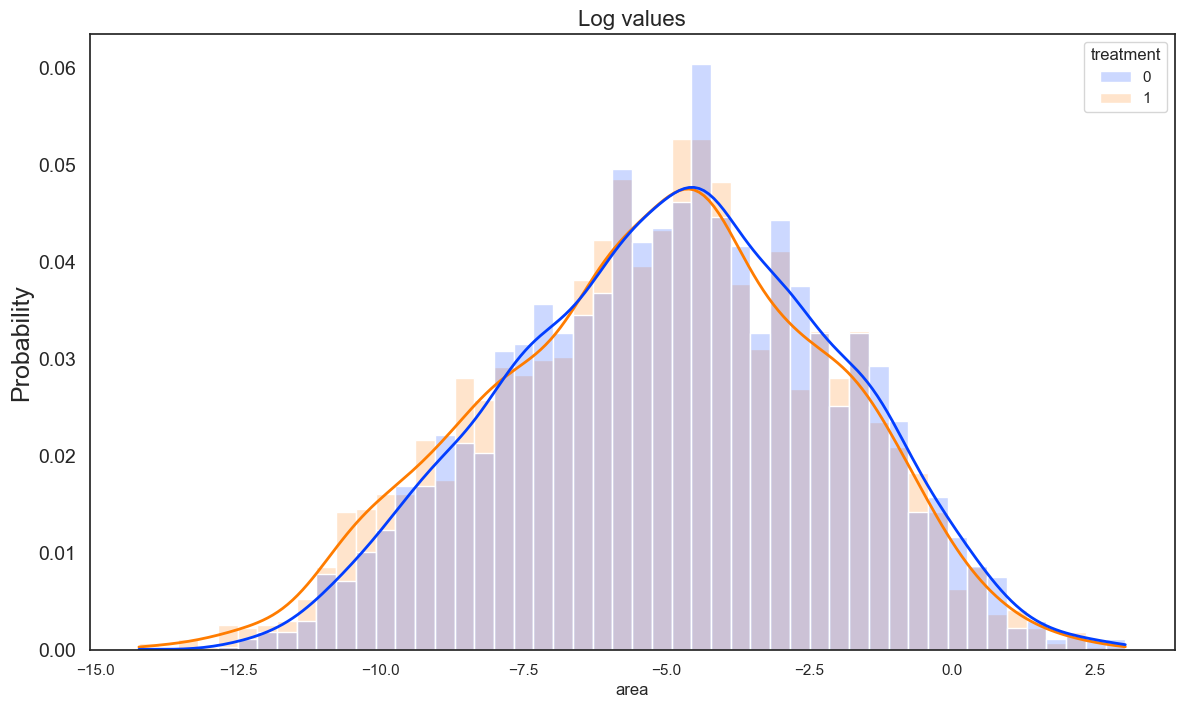

In [19]:
sns.set_style('white')

fig, axs = plt.subplots(figsize=(14,8))

opt = {'bins': 50, 'alpha': 0.2, 'palette': 'bright',
        'stat': 'probability', 'kde': True,
        'line_kws': {'lw': 2}, 'common_norm': False}

sns.histplot(data=data_all, x='area', hue='treatment', ax=axs, legend=True, **opt)
axs.set_title('Log values', fontsize=16)
axs.set_ylabel('Probability', fontsize=18)
axs.tick_params(axis='y', labelsize=14)

fig.savefig(os.path.join(data_path,"distribution-3cases-no-date.png"), format='png', facecolor='w', dpi=300)

plt.show()

### PLOTS

In [22]:
def adjustlabels(fig, labels, max_iter=1000, eps=0.01, delta=0.1, 
                 clip_to_axes=True, pad=0.1):
    N = len(labels)
    widths = np.zeros(N)
    heights = np.zeros(N)
    centers = np.zeros((N, 2))
    for i,l in enumerate(labels):
        bb = l.get_window_extent(renderer=fig.canvas.get_renderer())
        bb = bb.transformed(plt.gca().transData.inverted())
        widths[i] = bb.width
        heights[i] = bb.height
        centers[i] = (bb.min + bb.max)/2
        
    ylim = plt.gca().get_ylim()
    xlim = plt.gca().get_xlim()    

    def clip():
        for i in range(N):
            centers[i,0] = max(centers[i,0], xlim[0] + widths[i]/2 + pad)
            centers[i,0] = min(centers[i,0], xlim[1] - widths[i]/2 - pad)
            centers[i,1] = max(centers[i,1], ylim[0] + heights[i]/2 + pad)
            centers[i,1] = min(centers[i,1], ylim[1] - heights[i]/2 - pad)
            labels[i].set_position(centers[i])
    clip()

    for i in range(max_iter):
        stop = True
        for a in range(N):
            for b in range(N):
                if ((a!=b) and
                    (np.abs(centers[a,0]-centers[b,0]) < (widths[a]+widths[b])/2 + delta) and
                    (np.abs(centers[a,1]-centers[b,1]) < (heights[a]+heights[b])/2 +  delta)):
                    
                    d = centers[a] - centers[b]
                    centers[a] += d * eps
                    centers[b] -= d * eps
                    labels[a].set_position(centers[a])
                    labels[b].set_position(centers[b])
                    if clip_to_axes:
                        clip()
                    stop = False
        if stop:
            break

In [23]:
def plot_volcano(results_all, fc_threshold=0.3, pvalue_threshold=1.5, filename="test.png"):

    class TextHandlerB(HandlerBase):
        def create_artists(self, legend, text ,xdescent, ydescent,
                            width, height, fontsize, trans):
            tx = Text(width/2.,height/2, text, fontsize=fontsize,
                    ha="center", va="center", fontweight="bold")
            return [tx]

    Legend.update_default_handler_map({str : TextHandlerB()})       
    
    #col = np.where(np.log2(results_all['fc']) < -fc_threshold,'r',np.where(np.log2(results_all['fc']) > fc_threshold,'g','k'))
    col = np.where(-np.log10(results_all['p']) < pvalue_threshold, 'k', 
                            np.where(np.log2(results_all['fc']) < -fc_threshold,'r',np.where(np.log2(results_all['fc']) > fc_threshold,'g','k')))

    fig = plt.figure(figsize=(14,12))
    plt.scatter(np.log2(results_all['fc']), -np.log10(results_all['p']), c=col)
    y_max_value = plt.gca().get_ylim()[1]
    shownlabels = []
    l_ha = ['right','left']
    elem_counter = 1
    legend_data_handles = []
    legend_data_labels = []
    for i in range(results_all.shape[0]): 

        x = np.log2(results_all.iloc[i]['fc'])
        y = -np.log10(results_all.iloc[i]['p'])
        aa = np.random.rand()*3 - 1.5 + 0.5 * np.sign(x)
        ii = np.sign(aa) * 0.5 + 0.5
        if (np.abs(x) > fc_threshold) and (y > pvalue_threshold):
            l = plt.text(x, y + 0.03*y_max_value, elem_counter, va='center', color='k', fontsize=14, zorder=10,bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.1))
            """ l = plt.text(x+0.01*aa, y,
                         results_all.iloc[i]['lipid'],ha=l_ha[int(ii)], va='center', color='k', 
                         fontsize=10, zorder=10,bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2)) """
            #shownlabels.append(l)
            legend_circle = Line2D([0], [0], marker='o', color='w', markerfacecolor='r' if x < -fc_threshold else 'g', markersize=10)
            legend_data_handles.append(legend_circle)
            legend_data_labels.append(str(elem_counter) + '-' + results_all.iloc[i]['lipid'])
            #legend_data_keeper.update({str(elem_counter): results_all.iloc[i]['lipid']})
            elem_counter += 1
    #adjustlabels(fig, shownlabels)
    plt.legend(handles=legend_data_handles,labels=legend_data_labels, loc='upper left', bbox_to_anchor=(1, 0.5), title='Legend')
    plt.xlabel('log FC',)
    plt.ylabel('-log10 (Pvalue)')
    plt.rc('axes', labelsize=18) 
    fig.savefig(os.path.join(data_path,filename), format='png', facecolor='w', dpi=300)

    plt.show()

#### Let's prepare the data for the volcano plot

In [25]:
metabolites_list = data_all['metabolite'].unique()
len(metabolites_list)

207

In [26]:
import itertools
factor = 'treatment'
results_all = []
for l in metabolites_list:
    data_metabolite = data_all[data_all['metabolite'] == l]
    if data_metabolite[factor].unique().size > 1: # Some metabolties are not found in both classes
        for c in itertools.combinations(data_metabolite[factor].unique(),2):
            a = data_metabolite[data_metabolite[factor] == c[0]]['area'].values
            b = data_metabolite[data_metabolite[factor] == c[1]]['area'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            cd = np.abs((np.mean(a) - np.mean(b)))
            cd /= np.sqrt(
                ((a.size - 1)*np.var(a) + (b.size - 1)*np.var(b)) / (a.size + b.size - 2)
            )
            n_samples = a.size
            sp = TTestIndPower().power(effect_size=cd, nobs1=n_samples, alpha=0.05)
            results_all.append([l, fc, pvalue, c[0], c[1], cd, n_samples, sp])

colnames = ['lipid', 'fc', 'p', factor+'1', factor+'2', 'effectSize', 'sampleSize', 'statisticalPower']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

,lipid,fc,p,treatment1,treatment2,effectSize,sampleSize,statisticalPower
0,1 or 3-Methyl-Histidine.1,0.956537,0.523147,0,1,0.235911,16,0.099029
1,1-Methyl-Histidine.1,0.997004,0.961970,0,1,0.022792,10,0.050267
2,2'-O-Methyl Guanosine.1,0.962294,0.432549,0,1,0.290490,16,0.125062
3,2'-O-Methyl Uridine.1,0.988432,0.811414,0,1,0.087896,16,0.056666
4,2-Aminooctanoic acid.1,0.880420,0.271780,0,1,0.534449,10,0.204835


c:\Users\ibern\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\ibern\AppData\Local\Temp\ipykernel_27276\3849264033.py:26: RuntimeWarning: invalid value encountered in log2
  x = np.log2(results_all.iloc[i]['fc'])


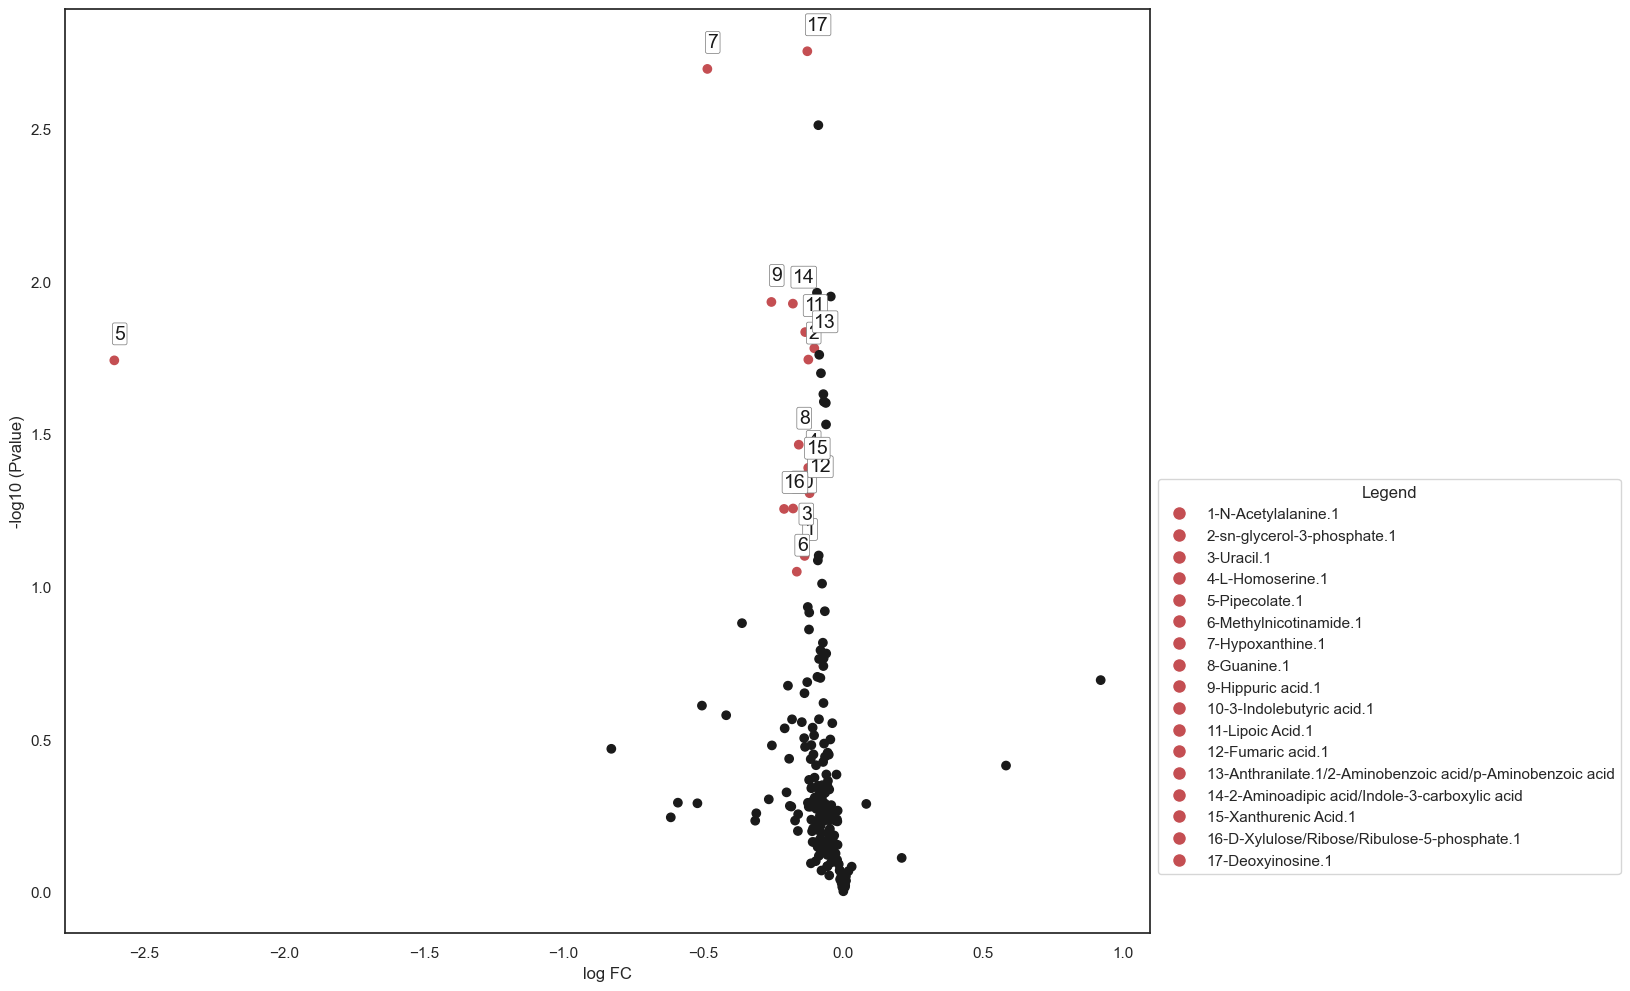

In [27]:
plot_volcano(results_all,fc_threshold=0.1, pvalue_threshold=1, filename="volcano-plot-treatment.png")

# STATISTICS

### Wilcoxon test

In [20]:
var_name = 'area'

a = data_all[data_all['treatment'] == 0][var_name]
b = data_all[data_all['treatment'] == 1][var_name]

a = a.dropna()
b = b.dropna()

print(f'P-value: {ranksums(a,b).pvalue:.2e}')

P-value: 1.70e-03


### T-test

In [21]:
var_name = 'area'

a = data_all[data_all['treatment'] == 0][var_name]
b = data_all[data_all['treatment'] == 1][var_name]

a = a.dropna()
b = b.dropna()

print(f'P-value: {ttest_ind(a,b).pvalue:.2e}')

P-value: 3.42e-04
